<img src="../Pics/MLSb-T.png" width="160">
<br><br>
<center><u><H1>Word2Vec-CBOW-Keras</H1></u></center>

In [1]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.Session(config=config)
set_session(sess)

Using TensorFlow backend.


In [2]:
from keras.layers import Embedding, Dense, Lambda
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras.backend as K
import nltk

In [3]:
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer #takes into consideration the morphological analysis of the words
from nltk.stem.porter import PorterStemmer ##cutting off the end or the beginning of the word

In [4]:
remove_terms = punctuation + '0123456789'

In [5]:
def preprocessing(text):
    words = word_tokenize(text)
    tokens = [w for w in words if w.lower() not in remove_terms]
    #stopw = stopwords.words('english')
    #tokens = [token for token in tokens if token not in stopw]
    #tokens = [word for word in tokens if len(word) >= 3]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    lemma = WordNetLemmatizer()
    tokens = [lemma.lemmatize(word) for word in tokens]    
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

In [6]:
corpus = open("../data/History_of_Astronomy.txt", encoding="utf8").readlines()

In [7]:
corpus = [preprocessing(sentence) for sentence in corpus if sentence.strip() !='']
corpus

['Project Gutenberg EBook of History of Astronomy by George Forbes',
 'Title History of Astronomy',
 'Author George Forbes',
 'Illustration SIR ISAAC NEWTON From the bust by Roubiliac In Trinity',
 'College Cambridge',
 'HISTORY OF ASTRONOMY',
 'BY',
 'GEORGE FORBES',
 'INST',
 'FORMERLY PROFESSOR OF NATURAL PHILOSOPHY ANDERSON COLLEGE GLASGOW',
 'AUTHOR OF THE TRANSIT OF VENUS RENDU THEORY OF THE GLACIERS OF',
 'SAVOY ETC',
 'CONTENTS',
 'PREFACE',
 'BOOK I THE GEOMETRICAL PERIOD',
 'PRIMITIVE ASTRONOMY AND ASTROLOGY',
 'ANCIENT ASTRONOMY CHINESE AND CHALDÆANS',
 'ANCIENT GREEK ASTRONOMY',
 'THE REIGN OF EPICYCLES FROM PTOLEMY TO COPERNICUS',
 'BOOK II THE DYNAMICAL PERIOD',
 'DISCOVERY OF THE TRUE SOLAR SYSTEM TYCHO BRAHE KEPLER',
 'GALILEO AND THE TELESCOPE NOTIONS OF GRAVITY BY HORROCKS ETC',
 'SIR ISAAC NEWTON LAW OF UNIVERSAL GRAVITATION',
 'NEWTON SUCCESSORS HALLEY EULER LAGRANGE LAPLACE ETC',
 'DISCOVERY OF NEW PLANETS HERSCHEL PIAZZI ADAMS AND LE',
 'VERRIER',
 'BOOK III OBSER

In [8]:
tokenizer = Tokenizer()

In [9]:
tokenizer.fit_on_texts(corpus)

In [10]:
X_train_tokens = tokenizer.texts_to_sequences(corpus)

In [11]:
items = tokenizer.word_index.items()

In [12]:
word2id = tokenizer.word_index
id2word = dict([(value, key) for (key, value) in word2id.items()])

In [13]:
vocab_size = len(word2id) + 1
vocab_size

4411

In [14]:
embed_size = 300
window_size = 2

In [15]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])   
            
            label_word.append(word)

            x = pad_sequences(context_words, maxlen=context_length)
            y = to_categorical(label_word, vocab_size)
            yield (x, y)

In [16]:
i = 0
for x, y in generate_context_word_pairs(corpus=X_train_tokens, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['project', 'gutenberg', 'of', 'history'] -> Target (Y): ebook
Context (X): ['gutenberg', 'ebook', 'history', 'of'] -> Target (Y): of
Context (X): ['ebook', 'of', 'of', 'astronomy'] -> Target (Y): history
Context (X): ['of', 'history', 'astronomy', 'by'] -> Target (Y): of
Context (X): ['history', 'of', 'by', 'george'] -> Target (Y): astronomy
Context (X): ['of', 'astronomy', 'george', 'forbes'] -> Target (Y): by
Context (X): ['illustration', 'sir', 'newton', 'from'] -> Target (Y): isaac
Context (X): ['sir', 'isaac', 'from', 'the'] -> Target (Y): newton
Context (X): ['isaac', 'newton', 'the', 'bust'] -> Target (Y): from
Context (X): ['newton', 'from', 'bust', 'by'] -> Target (Y): the
Context (X): ['from', 'the', 'by', 'roubiliac'] -> Target (Y): bust


## Creating the model:

We have input context words of dimensions (2 x window_size), we will pass them to an embedding layer of size (vocab_size x embed_size) which will give us dense word embeddings for each of these context words (1 x embed_size for each word). Next up we use a lambda layer to average out these embeddings and get an average dense embedding (1 x embed_size) which is sent to the dense softmax layer which outputs the most likely target word. We compare this with the actual target word, compute the loss, backpropagate the errors to adjust the weights (in the embedding layer) and repeat this process for all (context, target) pairs for multiple epochs.

In [17]:
model = Sequential()

In [18]:
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embed_size,
                   embeddings_initializer='glorot_uniform',
                   input_length=window_size*2))

In [19]:
model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))

In [20]:
model.add(Dense(vocab_size, kernel_initializer='glorot_uniform', activation='softmax'))

## Model Summary

In [21]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4, 300)            1323300   
_________________________________________________________________
lambda_1 (Lambda)            (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4411)              1327711   
Total params: 2,651,011
Trainable params: 2,651,011
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

## Training the model:

In [23]:
%%time
n_epochs = 10
for epoch in range(n_epochs):
    loss = 0.
    for x, y in generate_context_word_pairs(corpus=X_train_tokens, window_size=window_size, vocab_size=vocab_size):
        loss += model.train_on_batch(x, y)

    print('Epoch:', epoch, '\tLoss:', loss)

Epoch: 0 	Loss: 262602.5064575039
Epoch: 1 	Loss: 237117.0089488253
Epoch: 2 	Loss: 213470.20108183543
Epoch: 3 	Loss: 190073.3735583169
Epoch: 4 	Loss: 170326.81564509665
Epoch: 5 	Loss: 154556.75656005595
Epoch: 6 	Loss: 142711.21915590722
Epoch: 7 	Loss: 133885.405729591
Epoch: 8 	Loss: 127206.68449070735
Epoch: 9 	Loss: 122285.18038794067
Wall time: 30min 14s


## Word Embeddings Vectors:

In [24]:
weights = model.get_weights()[0]
weights = weights[1:]
print(weights.shape)

(4410, 300)


In [25]:
pd.DataFrame(weights, index=list(id2word.values())).head(30)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
the,0.197311,-0.321102,-0.104788,-0.211072,-0.060051,0.119751,-0.009048,0.063433,-0.109678,-0.146437,...,-0.287251,0.042242,0.015941,0.482914,0.032606,-0.092885,-0.810725,0.194858,-0.786981,-0.037090
of,-0.719671,-0.130698,-0.246123,-0.254280,-0.005794,0.206934,0.844758,0.575476,-0.011601,-0.195015,...,0.432603,-0.264289,1.541351,1.603528,-0.261770,0.043277,0.191032,0.088460,-0.609696,0.051246
and,1.429149,-0.551750,0.136366,-0.337202,0.044456,-0.247486,0.659367,-0.251712,0.653903,0.047300,...,1.172975,-0.016912,0.116214,2.444677,0.047132,-1.716478,1.176980,0.039897,-0.428640,-0.241575
a,0.049388,-0.530273,0.289925,-0.211409,0.127528,0.064722,0.178980,0.429523,0.438987,0.111178,...,0.158414,-0.148880,-0.224122,0.716833,0.047357,0.716721,-0.517303,0.206474,-0.196543,0.026728
to,0.171544,-0.350725,0.110048,-0.525134,-0.002006,-0.053018,0.328167,1.492997,-0.339789,-0.130548,...,0.206873,0.169110,-0.155081,0.523979,-0.046734,-0.742548,-0.087107,0.310468,0.005661,0.190236
in,0.728589,-0.815809,0.306673,-0.327673,0.094002,-0.068043,0.335298,1.513581,0.830316,-0.185027,...,0.227538,-0.033712,0.750523,2.015462,-0.124203,-1.902325,-0.373950,-0.728567,-0.231213,0.061641
that,-0.503964,-0.174739,0.471179,-0.181306,0.135170,0.049771,-0.058478,-0.018701,0.105612,-0.196504,...,0.319682,0.245385,-0.206961,0.539366,-0.080182,-0.457259,-0.496409,-0.015274,0.115283,-0.066822
it,0.198396,0.170879,-0.385934,0.132759,-0.029226,0.208862,-0.198682,0.081810,0.027266,-0.095660,...,0.937169,0.298916,0.872772,-0.111539,0.088520,0.170527,-0.638614,-0.242562,-0.298687,-0.261077
by,0.833389,-0.691453,0.242072,-0.370731,0.122789,0.115845,0.358365,-0.207041,0.417088,-0.549719,...,-0.076547,-0.038922,-0.167818,-0.241455,0.098433,-3.182876,-0.477698,0.311139,-0.450023,-0.013052
wa,0.977805,0.090422,0.007853,-0.304827,-0.101879,0.234900,0.728454,0.398555,-0.340063,0.253184,...,0.031895,-0.175131,0.961765,0.749129,0.221698,-1.062602,-0.134467,0.606245,0.170058,0.020045


## Similar words:

In [26]:
distance_matrix = cosine_similarity(weights)
print(distance_matrix.shape)

(4410, 4410)


In [34]:
similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['copernicus', 'system', 'sun', 'halley', 'kepler','discovery','ancient']}
similar_words

{'copernicus': ['glorious', 'mayer', 'elapsed', 'uncertainty', 'violet'],
 'system': ['slightly', 'perfect', 'teem', 'christie', 'everywhere'],
 'sun': ['owe', 'sending', 'opened', 'since', 'however'],
 'halley': ['stage', 'debilitated', 'complete', 'fuller', 'nicolai'],
 'kepler': ['mayer', 'within', 'providing', 'skilful', 'biddell'],
 'discovery': ['meteoric', 'meteors', 'mounted', 'approaching', 'vintage'],
 'ancient': ['dip', 'guinand', 'collecting', 'finally', 'impressive']}

## Visualizing words relationships:

In [35]:
words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [word2id[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])
print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)

Total words: 42 	Word Embedding shapes: (42, 300)


In [41]:
tsne = TSNE(n_components=2, random_state=2018, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

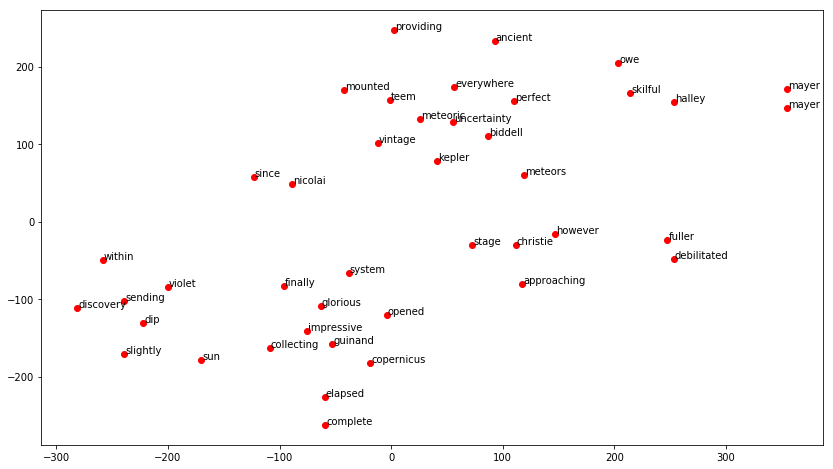

In [42]:
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='red')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## Reference:

https://www.tensorflow.org/tutorials/representation/word2vec